In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_W4G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sat Mar 13 16:48:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 39%   56C    P0    85W / 370W |      0MiB / 24268MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 56%   

In [10]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/scpark/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [3]:
save_dir = 'save/model_W4G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json   save_20000	save_40000  save_55000	save_70000  save_85000
save_0	    save_25000	save_45000  save_58657	save_75000  save_85150
save_10000  save_30000	save_5000   save_60000	save_80000
save_15000  save_35000	save_50000  save_65000	save_82879


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 85150

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 124.1MiB
TTS size 36.5MiB
MelEncoder size 11.6MiB
MelDecoder size 22.9MiB
loaded : 85150
85150
done


In [6]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.03625152111053467


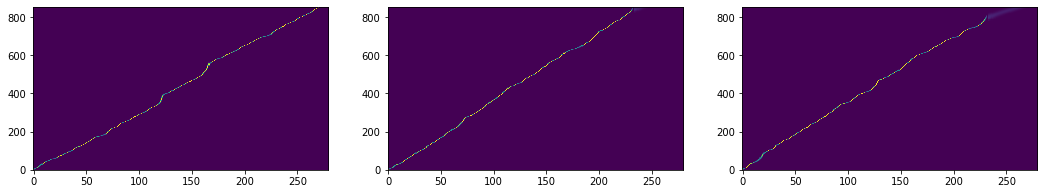

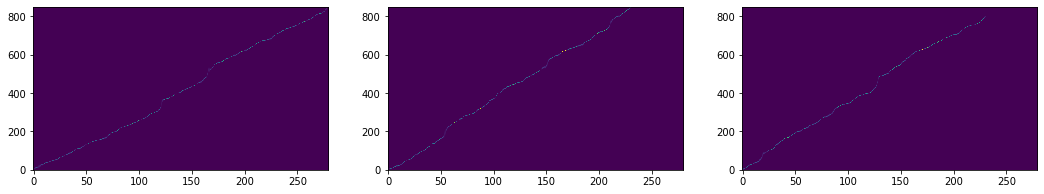

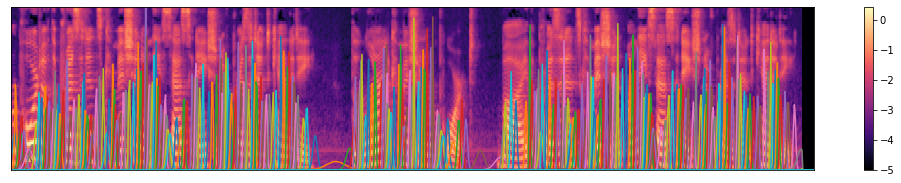

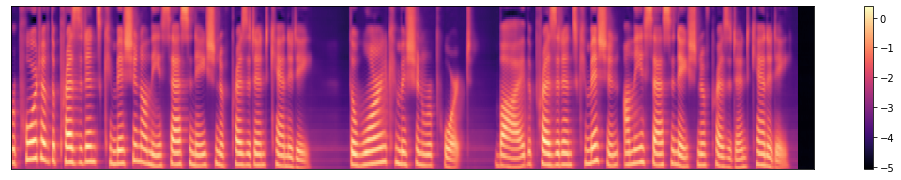

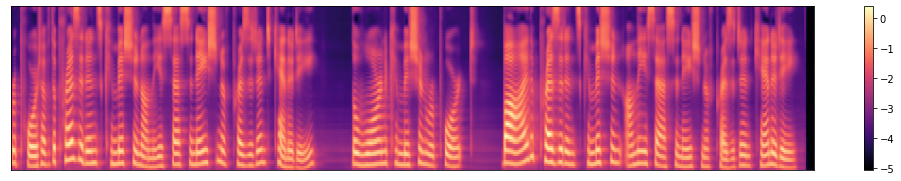

tensor(0.1647, device='cuda:0')
step : 97801 stt : 0.0007 tts : 0.1478 recon : 0.0307 kl : 0.0102 beta : 1.0000
tensor(0.2089, device='cuda:0')
step : 97802 stt : 0.0016 tts : 0.1523 recon : 0.0308 kl : 0.0101 beta : 1.0000
tensor(0.1396, device='cuda:0')
step : 97803 stt : 0.0009 tts : 0.1283 recon : 0.0300 kl : 0.0100 beta : 1.0000
tensor(0.1751, device='cuda:0')
step : 97804 stt : 0.0013 tts : 0.1495 recon : 0.0297 kl : 0.0099 beta : 1.0000
tensor(0.2300, device='cuda:0')
step : 97805 stt : 0.0016 tts : 0.1379 recon : 0.0320 kl : 0.0103 beta : 1.0000
tensor(0.2144, device='cuda:0')
step : 97806 stt : 0.0010 tts : 0.1286 recon : 0.0281 kl : 0.0095 beta : 1.0000
tensor(0.2134, device='cuda:0')
step : 97807 stt : 0.0005 tts : 0.1301 recon : 0.0292 kl : 0.0098 beta : 1.0000
tensor(0.2039, device='cuda:0')
step : 97808 stt : 0.0006 tts : 0.1261 recon : 0.0299 kl : 0.0099 beta : 1.0000
tensor(0.1953, device='cuda:0')
step : 97809 stt : 0.0010 tts : 0.1289 recon : 0.0256 kl : 0.0088 beta :

tensor(0.1905, device='cuda:0')
step : 97875 stt : 0.0017 tts : 0.1578 recon : 0.0315 kl : 0.0102 beta : 1.0000
tensor(0.1831, device='cuda:0')
step : 97876 stt : 0.0009 tts : 0.1444 recon : 0.0281 kl : 0.0094 beta : 1.0000
tensor(0.2130, device='cuda:0')
step : 97877 stt : 0.0016 tts : 0.1437 recon : 0.0284 kl : 0.0094 beta : 1.0000
tensor(0.1834, device='cuda:0')
step : 97878 stt : 0.0014 tts : 0.1628 recon : 0.0326 kl : 0.0105 beta : 1.0000
tensor(0.2105, device='cuda:0')
step : 97879 stt : 0.0011 tts : 0.1519 recon : 0.0308 kl : 0.0102 beta : 1.0000
tensor(0.1985, device='cuda:0')
step : 97880 stt : 0.0010 tts : 0.1507 recon : 0.0302 kl : 0.0100 beta : 1.0000
tensor(0.2067, device='cuda:0')
step : 97881 stt : 0.0008 tts : 0.1557 recon : 0.0305 kl : 0.0099 beta : 1.0000
tensor(0.2388, device='cuda:0')
step : 97882 stt : 0.0009 tts : 0.1455 recon : 0.0301 kl : 0.0099 beta : 1.0000


In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [18]:
logger.save(step, model, optimizer)

saved save/model_W4G/save_85150


that not more than one bottle of wine or one quart of beer could be issued at one time. No account was taken of the amount of liquors admitted in one day,
torch.Size([1, 80, 859]) 0.029932904243469238
{'alignment': 0.0003018379211425781, 'random': 0.0006902217864990234, 'last_conv': 0.020778894424438477, 'z_proj': 0.0004830360412597656, 'cond': 0.0006890296936035156, 'up': 0.0008478164672851562, 'encode': 0.004479408264160156, 'pad': 2.7179718017578125e-05, 'enc_conv': 0.0008406639099121094, 'enc_lstm': 0.0034644603729248047}


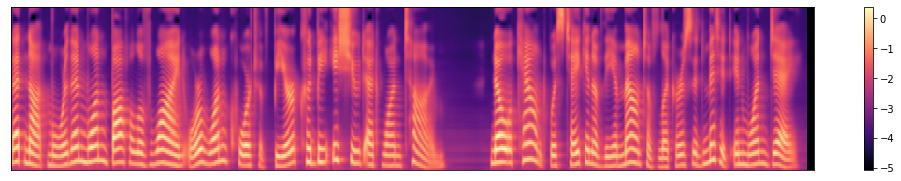

In [15]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 10:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0, clip=2)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [16]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(219904,)
